# **MIE1624 Assignment 1 Salary Classification Problem**

Tianyang Jiao 1000569413

Run time 750s in Google Colab

With 2 - CV hard coded, 119s in Google Colab
KFolds are not hard coded


*   RFECV
*   Grid Search



Raw data is from 2019 Kaggle ML&DS Survey Challenge.
This project aims to use features from the Kaggle dataset to predict the salary of people working in the data science field.

In [0]:
#Install necessary packages
#!pip install numpy
#!pip install pandas
#!pip install scikit-learn
#!pip install seaborn
#!pip install statsmodels

In [0]:
#import all libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import cross_val_score, KFold, learning_curve, validation_curve, train_test_split,GridSearchCV 

%matplotlib inline

In [0]:
#Supress all warnings in Cognitive Ai
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

# 1 Data Cleaning

Before predicting the target variable, first thing is to clean the data. This part contains steps taken to clean the dataset. The original dataset (multiple_choice-responses) has been modified into (Kaggle_Salary.csv) with target variable Q10_Encoded.

## 1.1 Read data

In [8]:
#read data from csv file
df = pd.read_csv('Kaggle_Salary.csv')
#Have a quick look at data
df.head(3)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (73,77,114,146,153,171,175,212,224,228,231) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Time from Start to Finish (seconds),Q1,Q2,Q2_OTHER_TEXT,Q3,Q4,Q5,Q5_OTHER_TEXT,Q6,Q7,Q8,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q9_OTHER_TEXT,Q10,Q11,Q12_Part_1,Q12_Part_2,Q12_Part_3,Q12_Part_4,Q12_Part_5,Q12_Part_6,Q12_Part_7,Q12_Part_8,Q12_Part_9,Q12_Part_10,Q12_Part_11,Q12_Part_12,Q12_OTHER_TEXT,Q13_Part_1,Q13_Part_2,Q13_Part_3,Q13_Part_4,Q13_Part_5,...,Q32_Part_2,Q32_Part_3,Q32_Part_4,Q32_Part_5,Q32_Part_6,Q32_Part_7,Q32_Part_8,Q32_Part_9,Q32_Part_10,Q32_Part_11,Q32_Part_12,Q32_OTHER_TEXT,Q33_Part_1,Q33_Part_2,Q33_Part_3,Q33_Part_4,Q33_Part_5,Q33_Part_6,Q33_Part_7,Q33_Part_8,Q33_Part_9,Q33_Part_10,Q33_Part_11,Q33_Part_12,Q33_OTHER_TEXT,Q34_Part_1,Q34_Part_2,Q34_Part_3,Q34_Part_4,Q34_Part_5,Q34_Part_6,Q34_Part_7,Q34_Part_8,Q34_Part_9,Q34_Part_10,Q34_Part_11,Q34_Part_12,Q34_OTHER_TEXT,Q10_Encoded,Q10_buckets
0,510,22-24,Male,-1,France,Master’s degree,Software Engineer,-1,"1000-9,999 employees",0,I do not know,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,"30,000-39,999",$0 (USD),Twitter (data science influencers),NaN,NaN,"Kaggle (forums, blog, social media, etc)",NaN,NaN,NaN,"Blogs (Towards Data Science, Medium, Analytics...",Journal Publications (traditional publications...,NaN,NaN,NaN,-1,NaN,Coursera,NaN,DataCamp,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,3,"30,000-39,999"
1,423,40-44,Male,-1,India,Professional degree,Software Engineer,-1,"> 10,000 employees",20+,"We have well established ML methods (i.e., mod...",Analyze and understand data to influence produ...,Build and/or run the data infrastructure that ...,Build prototypes to explore applying machine l...,Build and/or run a machine learning service th...,NaN,NaN,NaN,NaN,-1,"5,000-7,499","> $100,000 ($USD)",NaN,NaN,NaN,"Kaggle (forums, blog, social media, etc)",NaN,"YouTube (Cloud AI Adventures, Siraj Raval, etc)","Podcasts (Chai Time Data Science, Linear Digre...","Blogs (Towards Data Science, Medium, Analytics...",NaN,NaN,NaN,NaN,-1,NaN,Coursera,NaN,DataCamp,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,0,"0-9,999"
2,391,40-44,Male,-1,Australia,Master’s degree,Other,0,"> 10,000 employees",20+,I do not know,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,"250,000-299,999","$10,000-$99,999",NaN,NaN,NaN,NaN,NaN,NaN,"Podcasts (Chai Time Data Science, Linear Digre...","Blogs (Towards Data Science, Medium, Analytics...",Journal Publications (traditional publications...,"Slack Communities (ods.ai, kagglenoobs, etc)",NaN,NaN,-1,NaN,Coursera,edX,DataCamp,NaN,...,NaN,Azure Machine Learning Studio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Azure SQL Database,NaN,NaN,NaN,-1,14,">250,000"


In [9]:
#Display some one number summary of the dataset
df.describe()

,Time from Start to Finish (seconds),Q2_OTHER_TEXT,Q5_OTHER_TEXT,Q9_OTHER_TEXT,Q12_OTHER_TEXT,Q13_OTHER_TEXT,Q14_Part_1_TEXT,Q14_Part_2_TEXT,Q14_Part_3_TEXT,Q14_Part_4_TEXT,Q14_Part_5_TEXT,Q14_OTHER_TEXT,Q16_OTHER_TEXT,Q17_OTHER_TEXT,Q18_OTHER_TEXT,Q19_OTHER_TEXT,Q20_OTHER_TEXT,Q21_OTHER_TEXT,Q24_OTHER_TEXT,Q25_OTHER_TEXT,Q26_OTHER_TEXT,Q27_OTHER_TEXT,Q28_OTHER_TEXT,Q29_OTHER_TEXT,Q30_OTHER_TEXT,Q31_OTHER_TEXT,Q32_OTHER_TEXT,Q33_OTHER_TEXT,Q34_OTHER_TEXT,Q10_Encoded
count,12497.000000,12497.000000,12497.000000,12497.000000,12497.000000,12497.000000,12497.000000,12497.000000,12497.000000,12497.000000,12497.000000,12497.000000,12497.000000,12497.000000,12497.000000,12497.000000,12497.000000,12497.000000,12497.000000,12497.000000,12497.000000,12497.00000,12497.000000,12497.000000,12497.000000,12497.000000,12497.000000,12497.000000,12497.000000,12497.000000
mean,14186.510202,-0.963191,29.216932,-0.250940,8.103465,20.657998,25.922621,4.303833,3.934304,262.422101,8.751780,19.343923,4.449708,0.638553,3.492198,-0.778827,1.738017,-0.903097,1.333280,-0.519325,-0.959030,-0.96015,0.146995,-0.432104,-0.024486,-0.075458,-0.396975,-0.762663,0.084420,3.920061
std,72866.379285,0.978525,122.208237,8.257127,51.449272,101.726742,119.957741,33.044706,31.519867,615.567766,52.568255,96.161486,34.209404,14.242578,26.992550,3.159780,21.134610,1.792618,19.341912,5.936373,0.969486,0.93225,10.517404,6.495225,9.436367,9.187520,6.270585,3.395293,9.675712,4.188416
min,67.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,448.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
50%,636.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2.000000
75%,1054.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,56.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,7.000000
max,843612.000000,39.000000,877.000000,137.000000,491.000000,812.000000,935.000000,366.000000,337.000000,2840.000000,486.000000,763.000000,356.000000,208.000000,305.000000,74.000000,265.000000,53.000000,259.000000,113.000000,35.000000,31.00000,162.000000,113.000000,143.000000,142.000000,108.000000,74.000000,144.000000,14.000000


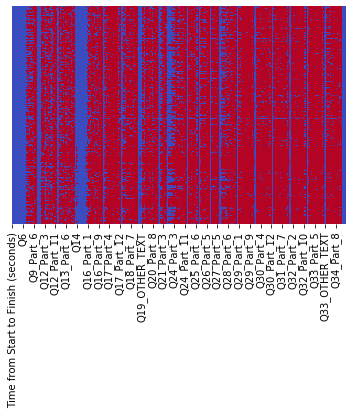

In [10]:
#find out if there is any missing data NaN
#Red points means missing NaN, this plot shows that I cannot simply remove all NaNs from the dataset, otherwise there wont be much left
fig, ax = plt.subplots()
sns.heatmap(df.isnull(), cmap="coolwarm", yticklabels=False, cbar=False, ax=ax )

##1.2 Treat missing data

At this step, the goal is to fillout as many NaNs as possible. The following steps contain my data cleaning approach. Trying not to drop any rows (data points). However, this later has been proven not useful. Drop features with more than 70% missing could be a more useful first step.

In [0]:
#with multiple choice question with many parts, fill NaN with 0.
#This is okay because NaN means they did not select that option (0 means not select).
#from CSV file and Kaggle compeition website, observed the no. of multiple choice questions allow multiple selections
#converted missing choice from NaN to 0 to assist further feature engineering
df.iloc[:,11:19]=df.iloc[:,11:19].fillna(0)
df.iloc[:,22:48]=df.iloc[:,22:48].fillna(0)
df.iloc[:,56:95]=df.iloc[:,56:95].fillna(0)
df.iloc[:,96:115]=df.iloc[:,96:115].fillna(0)
df.iloc[:,118:-3]=df.iloc[:,118:-3].fillna(0)

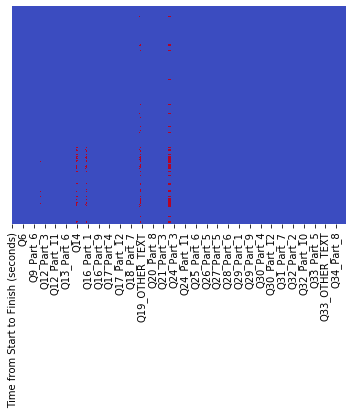

In [12]:
#Plot heatmap again to see affect on fill NaN with 0
fig, ax = plt.subplots()
sns.heatmap(df.isnull(), cmap="coolwarm", yticklabels=False, cbar=False, ax=ax )
#from here we can see that the heatmap is dominated by blue with very few NaN now

From the graph above, there are still some NaN values
More analysis is needed to further clean the data

In [13]:
#Determine the remining NaN values
df.loc[:,df.isnull().any()].describe()
#From here, one can see that Q11, 14, 15, 19, 22, 23 need more work
#the .describe() can give us infomration on categorical mode, no. of unique values to assist us fill the NaN

,Q11,Q14,Q15,Q19,Q22,Q23
count,12250,11452,11422,10653,10550,10541
unique,6,6,7,12,5,8
top,$0 (USD),"Local development environments (RStudio, Jupyt...",3-5 years,Python,Never,< 1 years
freq,4038,5925,2818,8200,8512,3068


In [14]:
#check the number of null in Q11, 247 is very small vs. all rows
df["Q11"].isnull().sum()

247

In [0]:
#drop Q11 NaN since the no. of missing response are low (total of 247 responses)
df=df.dropna(subset=["Q11"])

In [0]:
#fill Q22 NaN with Categorical Mode (highest frequency) value "Never"
#assume people never used it will not understand the term TPU
df["Q22"]=df["Q22"].fillna("Never")

In [0]:
#fill Q19 NaN with Categorical Mode (highest frequency) value "Python"
df["Q19"]=df["Q19"].fillna("Python")

In [18]:
#check the number of null in Q23
df['Q23'].isnull().sum()

1709

In [0]:
#Convert categorical age to numerical entry, select mid number and other's makes sense
df["Q1"]=df['Q1'].map({"18-21":20,"22-24":23,"25-29":27,"30-34":32,"35-39":37,"40-44":42,"45-49":47,"50-54":52,"55-59":57,"60-69":65,"70+":70})
#Here, age has been converted into numerical value

In [20]:
#Do further analysis on Q23
#read the null in Q23
df[df['Q23'].isnull()].head(3)

,Time from Start to Finish (seconds),Q1,Q2,Q2_OTHER_TEXT,Q3,Q4,Q5,Q5_OTHER_TEXT,Q6,Q7,Q8,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q9_OTHER_TEXT,Q10,Q11,Q12_Part_1,Q12_Part_2,Q12_Part_3,Q12_Part_4,Q12_Part_5,Q12_Part_6,Q12_Part_7,Q12_Part_8,Q12_Part_9,Q12_Part_10,Q12_Part_11,Q12_Part_12,Q12_OTHER_TEXT,Q13_Part_1,Q13_Part_2,Q13_Part_3,Q13_Part_4,Q13_Part_5,...,Q32_Part_2,Q32_Part_3,Q32_Part_4,Q32_Part_5,Q32_Part_6,Q32_Part_7,Q32_Part_8,Q32_Part_9,Q32_Part_10,Q32_Part_11,Q32_Part_12,Q32_OTHER_TEXT,Q33_Part_1,Q33_Part_2,Q33_Part_3,Q33_Part_4,Q33_Part_5,Q33_Part_6,Q33_Part_7,Q33_Part_8,Q33_Part_9,Q33_Part_10,Q33_Part_11,Q33_Part_12,Q33_OTHER_TEXT,Q34_Part_1,Q34_Part_2,Q34_Part_3,Q34_Part_4,Q34_Part_5,Q34_Part_6,Q34_Part_7,Q34_Part_8,Q34_Part_9,Q34_Part_10,Q34_Part_11,Q34_Part_12,Q34_OTHER_TEXT,Q10_Encoded,Q10_buckets
1,423,42,Male,-1,India,Professional degree,Software Engineer,-1,"> 10,000 employees",20+,"We have well established ML methods (i.e., mod...",Analyze and understand data to influence produ...,Build and/or run the data infrastructure that ...,Build prototypes to explore applying machine l...,Build and/or run a machine learning service th...,0,0,0,0,-1,"5,000-7,499","> $100,000 ($USD)",0,0,0,"Kaggle (forums, blog, social media, etc)",0,"YouTube (Cloud AI Adventures, Siraj Raval, etc)","Podcasts (Chai Time Data Science, Linear Digre...","Blogs (Towards Data Science, Medium, Analytics...",0,0,0,0,-1,0,Coursera,0,DataCamp,0,...,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,"0-9,999"
93,146,23,Male,-1,United States of America,Bachelor’s degree,Data Analyst,-1,0-49 employees,3-4,No (we do not use ML methods),0,0,0,0,0,0,0,0,-1,"60,000-69,999",$0 (USD),Twitter (data science influencers),0,"Reddit (r/machinelearning, r/datascience, etc)",0,"Course Forums (forums.fast.ai, etc)",0,0,0,0,"Slack Communities (ods.ai, kagglenoobs, etc)",0,0,-1,0,Coursera,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,-1,6,"60,000-69,999"
108,180,32,Male,-1,France,Doctoral degree,Research Scientist,-1,250-999 employees,3-4,No (we do not use ML methods),0,0,0,0,0,0,0,0,-1,"20,000-24,999",$0 (USD),0,0,0,0,0,"YouTube (Cloud AI Adventures, Siraj Raval, etc)",0,"Blogs (Towards Data Science, Medium, Analytics...",0,0,0,0,-1,0,Coursera,edX,DataCamp,0,...,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,-1,2,"20,000-29,999"


In [21]:
#use Q1 and Q8 to impute ansers for Q23
#Q1-Age, Q8-Does your current employer incorporate machine learning methods into their business?
df.groupby(["Q1","Q23"]).size()
#from this result, we see that most people select 1-2 years across all age groups. This result makes sense because the ML term is quite new. Therefore it will not help us to predict the salary

Q1  Q23        
20  1-2 years      117
    10-15 years      1
    2-3 years       38
    20+ years        1
    3-4 years        8
                  ... 
70  20+ years        7
    3-4 years        4
    4-5 years        4
    5-10 years       1
    < 1 years       14
Length: 88, dtype: int64

In [0]:
#drop Q23, since answers are already put into Q23 part answers (ex. Q23-PART 1... etc.)
df=df.drop(["Q23"],axis=1)

In [23]:
#Apply same methodology, visualize Q15
df.groupby(["Q1","Q15"]).size()

Q1  Q15                      
20  1-2 years                    153
    10-20 years                    2
    20+ years                      2
    3-5 years                     48
    5-10 years                     5
                                ... 
70  20+ years                     27
    3-5 years                      5
    5-10 years                     8
    < 1 years                      5
    I have never written code      4
Length: 77, dtype: int64

In [24]:
#use age to find the most common selection for Q15 (based on age group), then fill the NaN with the most common response
dic ={20:"1-2 years", 23:"1-2 years", 27:"3-5 years", 32:"3-5 years", 37:"5-10 years",42:"10-20 years",47:"3-5 years",52:"20+ years",57:"20+ years",65:"20+ years",70:"20+ years"}
df_temp = df.Q1.map(dic)
df.Q15 = df.Q15.combine_first(df_temp)
df.Q15.isnull().sum() #check to make sure no more NaN

0

In [25]:
#Apply same methodology, visualize Q14
df.groupby(["Q1","Q14"]).size()

Q1  Q14                                                                 
20  Advanced statistical software (SPSS, SAS, etc.)                          17
    Basic statistical software (Microsoft Excel, Google Sheets, etc.)        78
    Business intelligence software (Salesforce, Tableau, Spotfire, etc.)     24
    Cloud-based data software & APIs (AWS, GCP, Azure, etc.)                 30
    Local development environments (RStudio, JupyterLab, etc.)              196
                                                                           ... 
70  Advanced statistical software (SPSS, SAS, etc.)                          11
    Basic statistical software (Microsoft Excel, Google Sheets, etc.)        17
    Cloud-based data software & APIs (AWS, GCP, Azure, etc.)                  6
    Local development environments (RStudio, JupyterLab, etc.)               16
    Other                                                                    12
Length: 65, dtype: int64

In [26]:
#See the mode number
#From here, realized that Q14 selections are already contained in part answers
df['Q14'].value_counts()

Local development environments (RStudio, JupyterLab, etc.)              5925
Basic statistical software (Microsoft Excel, Google Sheets, etc.)       2094
Cloud-based data software & APIs (AWS, GCP, Azure, etc.)                1033
Other                                                                    871
Business intelligence software (Salesforce, Tableau, Spotfire, etc.)     787
Advanced statistical software (SPSS, SAS, etc.)                          742
Name: Q14, dtype: int64

In [0]:
#drop Q14 since one hot encoding info is contained in part answers
df=df.drop(["Q14"],axis=1)

##1.3 Convert Categorical data into Numerical

We need to convert categorical data into numerical data in order to feed into the logistic regression model. Two methods are used, one hot encoding and label encoding.

In [28]:
#Check no. of columns
col=[]
col=df.columns
n=2 #keep last 2 columns (targets)
col = col[:-n]
print("No. of columns except last 2 are", col)

No. of columns except last 2 are Index(['Time from Start to Finish (seconds)', 'Q1', 'Q2', 'Q2_OTHER_TEXT',
       'Q3', 'Q4', 'Q5', 'Q5_OTHER_TEXT', 'Q6', 'Q7',
       ...
       'Q34_Part_4', 'Q34_Part_5', 'Q34_Part_6', 'Q34_Part_7', 'Q34_Part_8',
       'Q34_Part_9', 'Q34_Part_10', 'Q34_Part_11', 'Q34_Part_12',
       'Q34_OTHER_TEXT'],
      dtype='object', length=244)


In [0]:
#Convert remaining positive entires to 1, -1 to 0. This inlcudes change others (non-stnadard entries such as 1, 2, 3, 4,... etc.) into 1
# 1,2,3,4... means that the other option allows text entries, one people's entry is different from each other
#In this case, we classifiy them into two groups, answered, no answer
#Question with long headings are greater than 12 character, short headings are greater than 4.
#>12, >4, are used to change these wrong entries
for i in range (1, 244): #244, length of the column
  if len(col[i]) > 12:
    df.iloc[:,i] = df.iloc[:,i].where(df.iloc[:,i]==-1,1) #change non -1 to 1
    df.iloc[:,i] = df.iloc[:,i].where(df.iloc[:,i]!=-1,0) #change -1 to 0
  elif len(col[i])>4:
    df.iloc[:,i] = df.iloc[:,i].where(df.iloc[:,i]==0,1) #change non 0 to 1

In [0]:
#One-hot encoding for non-ordinal data
#Q2 gender one-hot encoding male, female, and other (incl. perfer not to say & self-describe)
df["Q2"].replace("Prefer not to say","Other",inplace=True)
df["Q2"].replace("Prefer to self-describe","Other",inplace=True)
#drop Other since it only account for 1.5% of rows (inbalanced)
df = df[df.Q2 != "Other"]
#One-hot encoding, by using pd.get_dummies function
df=pd.get_dummies(df,columns=["Q2"],prefix="Q2-Sex")
#drop Q2_other since it does not contain much info
df=df.drop(["Q2_OTHER_TEXT"],axis=1)

In [31]:
#Unqiue value in Q3 - list of countries
np.unique(df["Q3"])

array(['Algeria', 'Argentina', 'Australia', 'Austria', 'Bangladesh',
       'Belarus', 'Belgium', 'Brazil', 'Canada', 'Chile', 'China',
       'Colombia', 'Czech Republic', 'Denmark', 'Egypt', 'France',
       'Germany', 'Greece', 'Hong Kong (S.A.R.)', 'Hungary', 'India',
       'Indonesia', 'Iran, Islamic Republic of...', 'Ireland', 'Israel',
       'Italy', 'Japan', 'Kenya', 'Malaysia', 'Mexico', 'Morocco',
       'Netherlands', 'New Zealand', 'Nigeria', 'Norway', 'Other',
       'Pakistan', 'Peru', 'Philippines', 'Poland', 'Portugal',
       'Republic of Korea', 'Romania', 'Russia', 'Saudi Arabia',
       'Singapore', 'South Africa', 'South Korea', 'Spain', 'Sweden',
       'Switzerland', 'Taiwan', 'Thailand', 'Tunisia', 'Turkey',
       'Ukraine', 'United Kingdom of Great Britain and Northern Ireland',
       'United States of America', 'Viet Nam'], dtype=object)

In [0]:
#Perform One-hot encoding to other categorical data
#For Q3, to reduce the number of countires, grouping countries into Region
#It would be too many features if I convert all countries. Based on their development and region, I decided group them into regions
#with India, USA, and other being the exceptions, they rank the top three countires where responses are gathered.

df['Q3']=df["Q3"].replace(['France', 'Netherlands', 'Germany', 'Ireland', 'Russia', 'Greece', 'Ukraine', 
                  'Belarus', 'United Kingdom of Great Britain and Northern Ireland', 'Sweden', 
                  'Portugal', 'Poland', 'Italy', 'Czech Republic', 'Spain', 'Turkey','Hungary', 
                  'Norway','Switzerland', 'Singapore', 'Romania','Belgium', 'Austria', 'Denmark'],"Europe")
df['Q3']=df['Q3'].replace(['Nigeria','Kenya','Morocco','Algeria','Tunisia','South Africa','Egypt'
], 'Africa')
df['Q3']=df['Q3'].replace(['Hong Kong (S.A.R.)','Japan','China','Taiwan','Pakistan','South Korea','Indonesia',
                  'Singapore','Israel','Viet Nam','Bangladesh',
                  'Iran, Islamic Republic of...','Hong Kong (S.A.R.)',
                  'Malaysia','Republic of Korea','Thailand','Philippines',
                  'Saudi Arabia'], 'Asia')
df['Q3']=df['Q3'].replace(['Australia','New Zealand'], 'Australia')
df['Q3']=df['Q3'].replace(['Brazil', 'Colombia', 'Argentina',
                            'Chile', 'Peru'], 'South America')
df['Q3']=df['Q3'].replace(['Mexico','Canada'], 'North America')
df_country=df['Q3'] #keep a copy for later use
#One-hot encoding, by using pd.get_dummies function
df=pd.get_dummies(df,columns=["Q3"],prefix="Q3")

In [0]:
#Perform Label Encoding encoding to other categorical data
#Q4 contains some orderly information, therefore it will switched to years of education
df=df[df.Q4!="I prefer not to answer"]
Q4_dic ={'No formal education past high school':12,
       'Some college/university study without earning a bachelor’s degree':13,
        'Bachelor’s degree':16,'Master’s degree':18, 'Professional degree':20,'Doctoral degree':21}
df["Q4"] = df['Q4'].map(Q4_dic)

In [0]:
#Perform One-hot encoding to other categorical data
#Q5 contains position/title of people
df=pd.get_dummies(df,columns=["Q5"],prefix="Q5")
df=df.drop(["Q5_OTHER_TEXT"],axis=1)

In [0]:
#Perform Label Encoding encoding to other categorical data
#Q6 baskets of compnay size, using same method as converting target variables
Q6_dic ={'0-49 employees':25, '1000-9,999 employees':5000, '250-999 employees':750,
       '50-249 employees':150, '> 10,000 employees':10000}
df["Q6"] = df['Q6'].map(Q6_dic)

In [0]:
#Perform Label Encoding encoding to other categorical data
#Q7 baskets of # of people working in this field, using same method as converting target variables
Q7_dic ={'0':0, '1-2':1, '10-14':10, '15-19':15, '20+':20, '3-4':3, '5-9':5}
df["Q7"] = df['Q7'].map(Q7_dic)

In [0]:
#Perform Label Encoding encoding to other categorical data
#Q8 baskets of # of years using ML in their company, using same method as converting target variables
#Different numerical score are given to each choices. One assumption is made. Companies used ML longer would award more salary to data people
Q8_dic ={'I do not know':-10, 'No (we do not use ML methods)':0,
       'We are exploring ML methods (and may one day put a model into production)':5,
       'We have well established ML methods (i.e., models in production for more than 2 years)':35,
       'We recently started using ML methods (i.e., models in production for less than 2 years)':20,
       'We use ML methods for generating insights (but do not put working models into production)':10}
df["Q8"] = df['Q8'].map(Q8_dic)

In [0]:
#delet Q10 since it has been converted to target variable already
df=df.drop(["Q10"],axis=1)
df=df.drop(["Q10_buckets"],axis=1)

In [0]:
#Perform Label Encoding encoding to other categorical data
#Q11 baskets of $ amount spent at ML (ordinal), using same method as converting target variables
#average is used
Q11_dic ={'$0 (USD)':0, '$1-$99':50, '$10,000-$99,999':50000, '$100-$999':500,
       '$1000-$9,999':5000, '> $100,000 ($USD)':100000}
df["Q11"] = df['Q11'].map(Q11_dic)

In [0]:
#Perform Label Encoding encoding to other categorical data
#Q15 describes the years they written code (ordinal), using same method as converting target variables
#average is used
Q15_dic ={'1-2 years':1.5, '10-20 years':15, '20+ years':20, '3-5 years':4, '5-10 years':7.5,
       '< 1 years':1, 'I have never written code':0}
df["Q15"] = df['Q15'].map(Q15_dic)

In [0]:
#Q19 are programming languages used, these are non-ordinal categorical data
#One-hot encoding, by using pd.get_dummies function
df=pd.get_dummies(df,columns=["Q19"],prefix="Q19")
df=df.drop(["Q19_OTHER_TEXT"],axis=1)

In [0]:
#Perform Label Encoding encoding to other categorical data
#Q22 describes how many times of use to TPU, using same method as converting target variables
#some braskets are grouped, with respect to salary wise
Q22_dic ={'2-5 times':2.5, '6-24 times':15, '> 25 times':25, 'Never':0, 'Once':1}
df["Q22"] = df['Q22'].map(Q22_dic)

##1.4 Confirm no NaN 

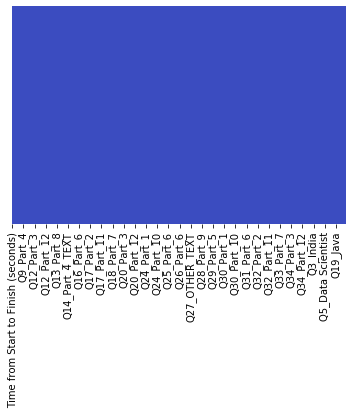

In [43]:
fig, ax = plt.subplots()
sns.heatmap(df.isnull(), cmap="coolwarm", yticklabels=False, cbar=False, ax=ax )
#No red spot means no NaN entries.

At this point, the data has been cleaned and encoded (no missing value, no categorical responses=all numerical). This dataset is already to be analyzed exploratorily and even fed into the model.

Answers to some questions.

Why some values are missing:
*   Column 1 is the automatically timed variable (from start to finish). One can see that the survey is a bit long and very detailed. Some people might not be comfortable with providing all the answers. They have the freedom to select choices based on their preference
*   People might also forget to answer some questions. It is possible too.
*   People might make errors while selecting their choices&text inputs. Note that this study did not attempt to find outliers. This is because the target variable range varies greatly from country to country and even within individual countries. There is an imbalance of wealth among data scientists. It would be hard to determine who "lied". On the bright side, we can assume there is only a small percentage of outliers and won't impact our model performance.

My action's impact on overall analysis:
*   Conservative approach has been taken during data cleaning. Very few entries and columns are dropped. These actions are not likely to have a major impact on model performance. 


# 2 Exploratory Data Analysis

## 2.1 Trends in the data

### 2.1.1 Salary histogram based on on. of responses

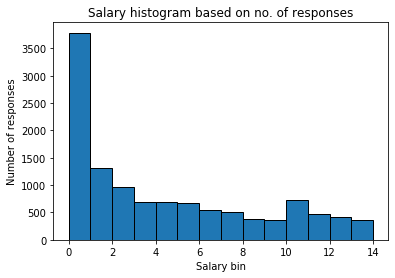

In [44]:
#salary histogram based on number of samples
plt.hist(df.Q10_Encoded, bins=14, edgecolor ='black')
plt.title('Salary histogram based on no. of responses')
plt.xlabel('Salary bin')
plt.ylabel('Number of responses')
plt.show()

From the figure above, it shows that majority of people have low salaries and wealthy people are less.

### 2.1.2 Box plot of salary range and age

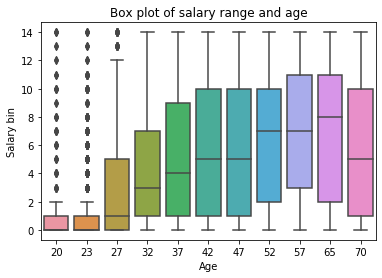

In [45]:
ax = sns.boxplot(x = df['Q1'], y = df['Q10_Encoded'])
plt.title('Box plot of salary range and age')
plt.xlabel('Age')
plt.ylabel('Salary bin')
plt.show()

From the plot we can see that salary increase with age and peaked at 65, then start to decline at 70. So salary is proportionate with experience. This and other numerical factor are likely to be good predicators.

### 2.1.3 Box plot of salary range vs. countries(regions)

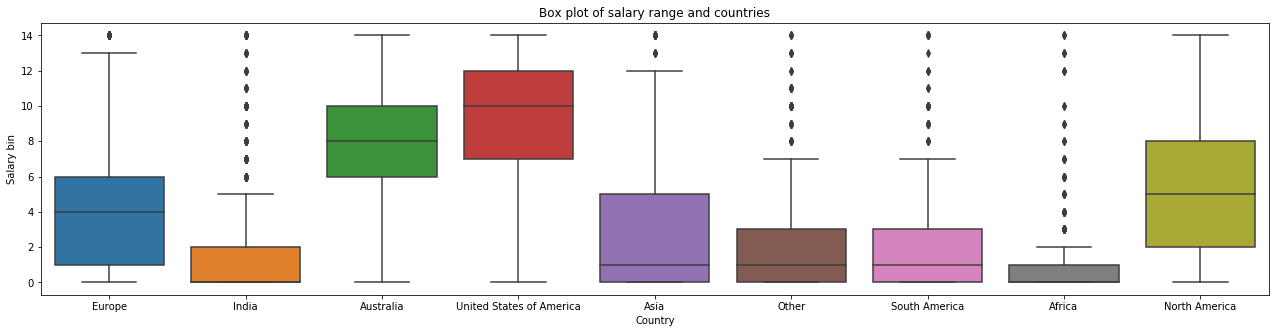

In [46]:
ax = sns.boxplot(x = df_country, y = df['Q10_Encoded'])
plt.title('Box plot of salary range and countries')
plt.xlabel('Country')
plt.ylabel('Salary bin')
fig =plt.gcf()
fig.set_size_inches(22,5)
plt.show()

From the figure above, we can see that people at USA has the highest salary, followed by Australia, and Europe. India being the top 3 region with the most responses have a surprisingly low salary. US or not US is likely to be a huge factor for their salary.

**How will these trends be used to help with the task of predicting yearly compensation or understanding the data?**



*   **Salary histogram based on no. of responses** - 
The first step of exploratory data analysis is to determine the general trends of the target variable. In this box plot, we can see that majority people's salary range fall under 0 & 1, and as salary increase, the no. of respondants.
*   **Box plot of salary range and age** - It is common sense that senior people with more experience would likely to have more salary. Age is a good surrogate for experience in coding and data science. This plot shows that salary does increase with age and drop until people retire at 60~70+.
*   **Box plot of salary range and countries** - This plot is interesting to see because all salary are normalized into US dollars. This is not a good target variable because for the same 100 US dollar has different purchasability at different places. The concept and numerical value of high salary are different in different countries. However, from a simple monetary point of view, US people do get more US dollars. India besides having more respondant (people woking in data science field) has lower compensations.

From these three Explorary Visual Analysis, the following comments can be made.
1. Logistic Regression performance for the whole dataset may not achieve a good accuracy due to the imbalanced dataset. For example, a same level data scientiest in US will definally get more money than his counter part in India.
2. These two variables are likely to be important for the model (age and country).
3. If someone is interest in predicting the compensation in an individual country, he/she might achieve a better result.






## 2.2 Visualize the order of feature importance

Correlation plot method is used to visualize the order of feature importance

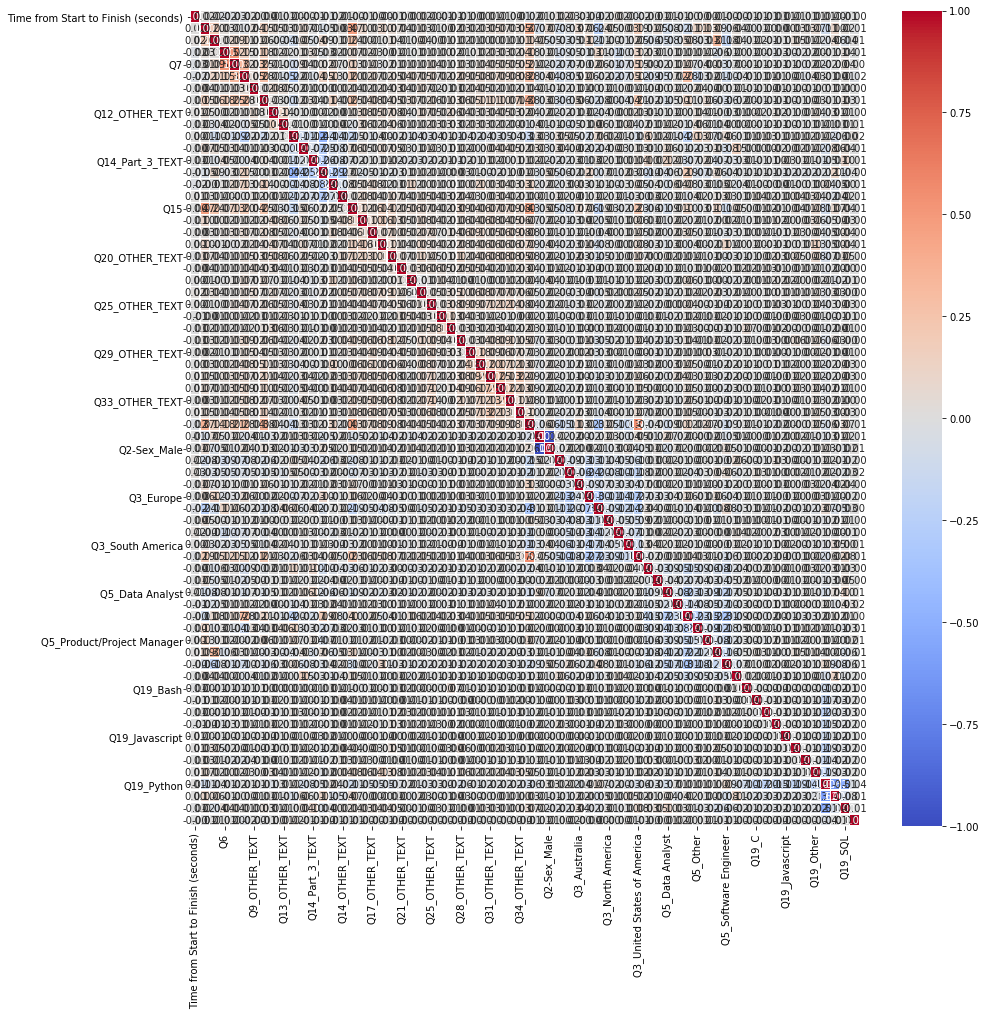

In [47]:
#Correlation plot - show the feature imporatance
sns.heatmap(df.corr(), cmap='coolwarm', annot=True, linewidths=0.2, fmt='.2f', annot_kws={'size':10}, )
fig =plt.gcf()
fig.set_size_inches(15,15)
plt.show()

At this point, it is obvious that I have too many features. Before Feature selection, I need to reduce the number of features.

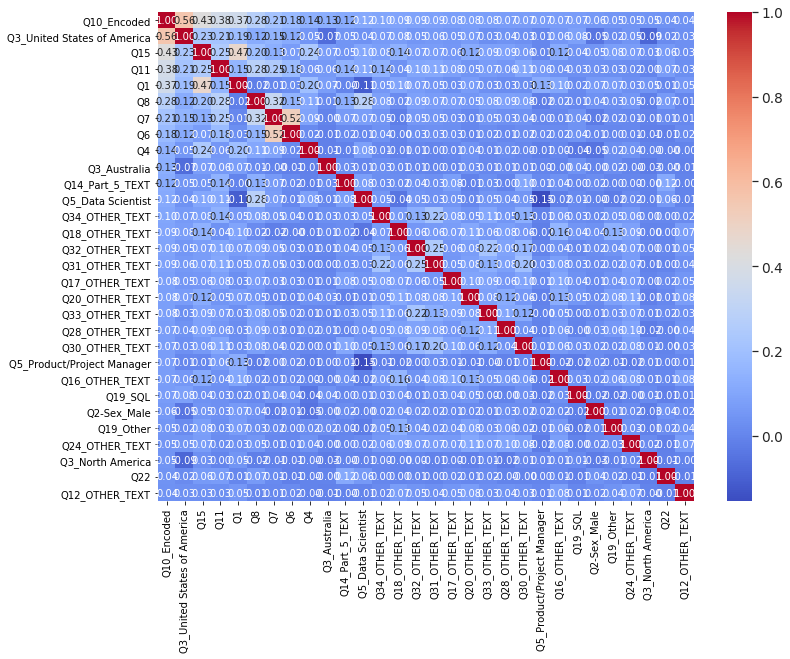

In [48]:
k=30 #no of top feature selected
corrmat=df.corr()
f,ax = plt.subplots(figsize=(12,9))

cols = corrmat.nlargest(k,'Q10_Encoded')['Q10_Encoded'].index #put Q10_Encoded target at the top
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
sns.heatmap(cm,cbar=True,annot=True,fmt='.2f',cmap='coolwarm', annot_kws={'size':10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

**Which of the original attributes in the data are most related to a survey respondent's yearly compensation?**

From the "reduced" correlation plot, we can see that the following features are most important:
1. Q3 - United States of America (After encoding 1 or 0 for belonging to USA)
2. Q15 - How long have you been writing code to analyze data (at work or at school)?
3. Q11 - Approximately how much money have you spent on machine learning and/or cloud computing products at your work in the past 5 years?
4. Q1 - What is your age (# years)?
5. Q8 - Does your current employer incorporate machine learning methods into their business?

With first 5 written out here, it coincide with my original assumption above. Age and USA are good predicators of final salary. Q15, Q11, Q8 are good question which can infer respondant's position(senior or not), companies attention on Machine learning, and their expertise in ML methods. 




# 3 Feature selection

**Feature engineering's importance in machine learning**

Data engineers and scientists often gets huge dataset with missing values. It is important to spend time on feature engineering to trim down the original dataset into a useable subset. In this case, the raw data contained many NaN and categorical entires. The logistic regression model can only accept numerical inputs. Thus, feature engineering is employed to treat the data before the model implementation.

Feature engineering is iterative in nature, after model implementation and testing, people can re-visit the feature engineering step to refine their data to gain better model performance.

Method 1 - Use the ranking from the corrolation plot, with corr ranking from build in fuction.
*   Mean accuracy score with CV + Grid Search =**0.3516**

With method 2 has a slightly higher Mean accuracy score, **this method has been dropped.**


From Part 2 correlation plot, we can see that therer are too many features. So based of the second **Ranked** correlation plot, I will delete some features first.

In [0]:
k=35 #no selected - manully selected through testing of logisitc regression model in an iterative manner.
corrmat=df.corr()
cols = corrmat.nlargest(k,'Q10_Encoded')['Q10_Encoded'].index

In [0]:
df_clean=df[['Q10_Encoded', 'Q3_United States of America', 'Q15', 'Q11', 'Q1', 'Q8',
       'Q7', 'Q6', 'Q4', 'Q3_Australia', 'Q14_Part_5_TEXT',
       'Q5_Data Scientist', 'Q34_OTHER_TEXT', 'Q18_OTHER_TEXT',
       'Q32_OTHER_TEXT', 'Q31_OTHER_TEXT', 'Q17_OTHER_TEXT', 'Q20_OTHER_TEXT',
       'Q33_OTHER_TEXT', 'Q28_OTHER_TEXT', 'Q30_OTHER_TEXT',
       'Q5_Product/Project Manager', 'Q16_OTHER_TEXT', 'Q19_SQL',
       'Q2-Sex_Male', 'Q19_Other', 'Q24_OTHER_TEXT', 'Q3_North America', 'Q22',
       'Q12_OTHER_TEXT', 'Q25_OTHER_TEXT', 'Q21_OTHER_TEXT', 'Q9_OTHER_TEXT',
       'Q29_OTHER_TEXT', 'Q27_OTHER_TEXT']]

Method 2

**This method is used**

Another way to perform feature selection using Sklearn buildin feature_selection Recursive Feature Engineering with Cross Validation (RFECV)
Estimator function is Lasso (with automatic feature selection)
*   Mean accuracy score with CV + Grid Search = 0.356



Below steps contain cross validation - commented out

In [51]:
'''
estimator = Lasso() #Use lasso's automatic feature selection method as estimator
X2 = df.loc[:,df.columns!='Q10_Encoded']
y2 = df['Q10_Encoded']
selector = RFECV(estimator, step=1, cv=5) #with cross validation 5 times
selector = selector.fit(X2,y2)
ranking = selector.ranking_ #use ranking of the selector to select feature
'''

"\nestimator = Lasso() #Use lasso's automatic feature selection method as estimator\nX2 = df.loc[:,df.columns!='Q10_Encoded']\ny2 = df['Q10_Encoded']\nselector = RFECV(estimator, step=1, cv=5) #with cross validation 5 times\nselector = selector.fit(X2,y2)\nranking = selector.ranking_ #use ranking of the selector to select feature\n"

In [52]:
'''
#Drop features based on ranking score
X2_selected = []
for i in range (len(ranking)):
  if ranking[i]<=50: #for ranking score beyond 50, drop the features
    X2_selected.append(i)
X2_clean = X2.iloc[:,X2_selected]
'''

'\n#Drop features based on ranking score\nX2_selected = []\nfor i in range (len(ranking)):\n  if ranking[i]<=50: #for ranking score beyond 50, drop the features\n    X2_selected.append(i)\nX2_clean = X2.iloc[:,X2_selected]\n'

In [0]:
#Used this code as hard code
X2_clean = df[['Time from Start to Finish (seconds)', 'Q1', 'Q4', 'Q6', 'Q7', 'Q8',
       'Q9_Part_1', 'Q9_Part_2', 'Q9_Part_3', 'Q9_Part_4', 'Q9_Part_5',
       'Q9_Part_6', 'Q9_Part_7', 'Q9_Part_8', 'Q9_OTHER_TEXT', 'Q11',
       'Q12_Part_1', 'Q12_Part_2', 'Q12_Part_3', 'Q12_Part_4', 'Q12_Part_5',
       'Q12_Part_6', 'Q12_Part_7', 'Q12_Part_8', 'Q12_Part_9', 'Q12_Part_10',
       'Q12_Part_11', 'Q12_Part_12', 'Q12_OTHER_TEXT', 'Q13_Part_1',
       'Q13_Part_2', 'Q13_Part_3', 'Q15', 'Q33_Part_11', 'Q33_Part_12',
       'Q33_OTHER_TEXT', 'Q34_Part_1', 'Q34_Part_2', 'Q34_Part_3',
       'Q34_Part_4', 'Q34_Part_5', 'Q34_Part_6', 'Q34_Part_7', 'Q34_Part_8',
       'Q34_Part_9', 'Q34_Part_10', 'Q34_Part_11', 'Q34_Part_12',
       'Q34_OTHER_TEXT', 'Q2-Sex_Female', 'Q2-Sex_Male', 'Q3_Africa',
       'Q3_Asia', 'Q3_Australia', 'Q3_Europe', 'Q3_India', 'Q3_North America',
       'Q3_Other', 'Q3_South America', 'Q3_United States of America',
       'Q5_Business Analyst', 'Q5_DBA/Database Engineer', 'Q5_Data Analyst',
       'Q5_Data Engineer', 'Q5_Data Scientist']]
y2 = df['Q10_Encoded']

**Reason for selecting 56 features (ranking score of 50)**
RFECV method only provide ranking of the features, it does not automatically remove features for you. Based on many repeated testings, 50 = threshold number has been selected.
By comparing RFECV method's top features (with higher ranking score), the result does not differ too much from correlation plot method. Thus a decision is made to keep 50 features.
After running both method. the RFECV is selected. Correlation method does not consider covariance between features. Thus I might have duplicated features.

In [54]:
#There are 56 features left
X2_clean.head() 

,Time from Start to Finish (seconds),Q1,Q4,Q6,Q7,Q8,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q9_OTHER_TEXT,Q11,Q12_Part_1,Q12_Part_2,Q12_Part_3,Q12_Part_4,Q12_Part_5,Q12_Part_6,Q12_Part_7,Q12_Part_8,Q12_Part_9,Q12_Part_10,Q12_Part_11,Q12_Part_12,Q12_OTHER_TEXT,Q13_Part_1,Q13_Part_2,Q13_Part_3,Q15,Q33_Part_11,Q33_Part_12,Q33_OTHER_TEXT,Q34_Part_1,Q34_Part_2,Q34_Part_3,Q34_Part_4,Q34_Part_5,Q34_Part_6,Q34_Part_7,Q34_Part_8,Q34_Part_9,Q34_Part_10,Q34_Part_11,Q34_Part_12,Q34_OTHER_TEXT,Q2-Sex_Female,Q2-Sex_Male,Q3_Africa,Q3_Asia,Q3_Australia,Q3_Europe,Q3_India,Q3_North America,Q3_Other,Q3_South America,Q3_United States of America,Q5_Business Analyst,Q5_DBA/Database Engineer,Q5_Data Analyst,Q5_Data Engineer,Q5_Data Scientist
0,510,23,18,5000,0,-10,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,1.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,423,42,20,10000,20,35,1,1,1,1,0,0,0,0,0,100000,0,0,0,1,0,1,1,1,0,0,0,0,0,0,1,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,391,42,18,10000,20,-10,0,0,0,0,0,0,0,0,0,50000,0,0,0,0,0,0,1,1,1,1,0,0,0,0,1,1,1.5,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,392,23,16,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,470,52,18,25,3,35,0,0,1,0,0,1,0,0,0,50000,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,20.0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1


# 4 Model Implementation

Implement logistic regression model using 10 fold cross-validation (KFold func) with Hyperparameter tuning (C)

## 4.1 Pre-processing

In [0]:
#Method 2 of feature selection employed
#split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X2_clean, y2, test_size =0.3, random_state=0)
X_trainc, X_testc, y_trainc, y_testc = X_train, X_test, y_train, y_test #create a copy

In [0]:
#Standard Scaler
#Apply scaling/normalization of features
std = StandardScaler().fit(X_train)
X_train=std.transform(X_train)
X_test=std.transform(X_test)

In [0]:
#get a list of target variable - used in later steps
#0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
y_class = np.sort(np.unique(y_train))

## 4.2 Ordinal Logistic Regression function (14 times one vs. rest)

In [0]:
#Ordinal logistic regression - 14 times one vs. rest
def OrdinalLogisticRegression_fit (X,y,C): #ask for C selection
  one_rest = {} #dictionary of binary classifiers

  if y_class.shape[0]>2: #if there is more than one y_class left (target 0 - 14)
    for i in range (y_class.shape[0]-1):
      binary_y = np.multiply((y>y_class[i]),1) #change rest target label into one number
      one_rest[i] = LogisticRegression(max_iter=1000, C=C).fit(X, binary_y) #perform one.vs rest Logistic regression

  return one_rest 

In [0]:
def OrdinalLogisticRegression_predict (X,one_rest):
  #predict_proba(X) calculated the probability of belonging to each of the salary buckets
  predicted = {y: one_rest[y].predict_proba(X) for y in one_rest}
  predicted_result =[] #contain probability of belonging to each of the salary buckets

  for i in y_class:
    if i == 0: #0 vs. 1-14
      predicted_result.append(1-predicted[i][:,1])
    elif i in predicted: #all middles
      predicted_result.append(predicted[i-1][:,1]-predicted[i][:,1])
    else: #last one
      predicted_result.append(predicted[i-1][:,1])

  predicted_result = np.vstack(predicted_result).T

  return np.argmax(predicted_result, axis =1) #the highest probability of the feature belongs to one target = target

## 4.3 Model Implementation (C=1.0) 

In [60]:
#Normal K fold =10 Ordinal logistic regression without Grid Search
cv_score =[]
kfold = KFold(n_splits=10, random_state=0, shuffle=False)
C = 1.0 #defalt model parameter
cv_mean={}
cv_var={}

for train_idx, test_idx in kfold.split(X_train):
  xf_train, xf_test = X_train[train_idx], X_train[test_idx]
  yf_train, yf_test = y_train.iloc[train_idx], y_train.iloc[test_idx]
  # apply above model
  clfs = OrdinalLogisticRegression_fit(xf_train, yf_train,C)
  y_pred = OrdinalLogisticRegression_predict(xf_test, clfs)

  accuracy = accuracy_score(yf_test, y_pred)

  cv_score.append(accuracy)

print('Mean accuracy score percentage', np.mean(cv_score)*100)
print('variance of accuracy score', format(round(np.var(cv_score),6)))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Mean accuracy score percentage 35.1786580016622
variance of accuracy score 0.000263


In [61]:
#Output of model accuracy score compare across 10 folds folds
cv_score

[0.35414165666266506,
 0.3637454981992797,
 0.3565426170468187,
 0.33373349339735897,
 0.38415366146458585,
 0.3433373349339736,
 0.3293269230769231,
 0.3389423076923077,
 0.36899038461538464,
 0.3449519230769231]

## 4.4 Model implementation (Hyperparameter tuning based on bias-variance tradeoff)

Bias variance trade off

C term = 1/lambda = model complexity

with increased model complexity, bias^2 term decrease (overfitting), but variance increase. Overall we want to minimize the total error = bias variance tradeoff. We need to find a optimum C value to get the minimum total error.



C values used 0.01,0.05,0.1,0.5,1,5,10

In [0]:
#Normal K fold =10 Ordinal logistic regression without Grid Search
cv_score =[]
kfold = KFold(n_splits=10, random_state=0, shuffle=False)
C = [0.01,0.05,0.1,0.5,1,5,10] #different hyperparameter
cv_mean={}
cv_var={}

for i in range (len(C)):
  for train_idx, test_idx in kfold.split(X_train):
    xf_train, xf_test = X_train[train_idx], X_train[test_idx]
    yf_train, yf_test = y_train.iloc[train_idx], y_train.iloc[test_idx]
    # apply above model
    clfs = OrdinalLogisticRegression_fit(xf_train, yf_train,C[i])
    y_pred = OrdinalLogisticRegression_predict(xf_test, clfs)

    accuracy = accuracy_score(yf_test, y_pred)

    cv_score.append(accuracy)
  cv_mean[i] = np.mean(cv_score)
  cv_var[i] = np.var(cv_score)
  cv_score = []
  
#print('Mean accuracy score percentage', np.mean(cv_score)*100)
#print('variance of accuracy score', format(round(np.var(cv_score),6)))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [0]:
#Hyperparameter tuning of C
#For 0 to 6, C = 0.01,0.05,0.1,0.5,1,5,10
#Result of cross validated mean accuracy score
cv_mean

{0: 0.35226677209345275,
 1: 0.3511851856127066,
 2: 0.35082504155508365,
 3: 0.3516663877089297,
 4: 0.351786580016622,
 5: 0.35226691638193736,
 6: 0.3521468683627297}

In [0]:
#Hyperparameter tuning of C
#For 0 to 6, C = 0.01,0.05,0.1,0.5,1,5,10
#Result of cross validated variance of accuracy score
cv_var

{0: 0.0002524477403690741,
 1: 0.00024226521238676532,
 2: 0.0002724624374876569,
 3: 0.00028133337705303965,
 4: 0.00026282085882951313,
 5: 0.0002606227896242314,
 6: 0.0002654905253416598}

**Result**
From the result above, C = 5, model achieved best overall mean accuracy score

# 5 Model Tunning

Bias - variance trade off
The default model used in step 4 (Logistic regression one vs. rest) has default C=1.0. C=1/lamda. lambda is the regulaizer in the cost function = a*m. Changing C is changing the hyperparameter. With in each one vs. rest, there is bias and variance tradeoff happening. With each C value being tested in the GridSearch function, the variance, bias have been calculated. The best C is selected when the total error is the smallest. This C value will be used for the later model to generate the best model.

**Thus, with the Grid Search func, for each one vs. all, one C value and best solver will be determined. There will be 14 C and 14 solver for the optimum model**

Model use L2 - lasso as default model parameter

## 5.1 Grid Search function

In [0]:
#Grid Search function from Logistic Regression notebook example

def GridSearch(X, y):
  model = LogisticRegression()
  scaler = StandardScaler()
  kfold = KFold(n_splits=10)
  kfold.get_n_splits(X)

  best_model = model
  best_params = {}
  best_accuracy = 0
  best_std = 0

  for C in [0.01,0.05,0.1,0.5,1,5,10]: # C = 1/lambda, adjust C adjust different lambda term on the loss function.
  #adjust C is the bias-variance tradeoff, see the performance of different lambda cross ten folds
  #after cross validation, best C hypermeter for each one vs. rest will be determine from the best accuracy score.
  #Bias vs. Variance trade off is complete with best parameter being selected
    for solver in ['newton-cg','lbfgs','liblinear']: #also test out different solver build in the Logistic regression model
      model = LogisticRegression(C=C, solver=solver)
      accuracy = np.zeros(10)
      np_idx = 0
      for train_idx, test_idx in kfold.split(X):
        X_train, X_test = X.values[train_idx], X.values[test_idx]
        y_train, y_test = y.values[train_idx], y.values[test_idx]

        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        
        TN = confusion_matrix(y_test, predictions)[0][0]
        FP = confusion_matrix(y_test, predictions)[0][1]
        FN = confusion_matrix(y_test, predictions)[1][0]
        TP = confusion_matrix(y_test, predictions)[1][1]
        total = TN + FP + FN + TP
        ACC = (TP + TN) / float(total)

        accuracy[np_idx] = ACC*100
        np_idx += 1
        if np.mean(accuracy) > best_accuracy:
          best_model = model
          best_params = {'C':C, 'solver':solver}
          best_accuracy = np.mean(accuracy)
          best_std = np.std(accuracy)

  return best_params

## 5.2 Perform Grid Search to find Best Parameters

Below code contain cross validation - very long - commented out

In [0]:
'''
#Perform Grid Search in training dataset to get best parameters
best_params = {}
#Only use training data
#X_trainc and y_trainc are not standard scalared, copied from above for GridSearch Only
for i in range (y_class.shape[0]-1):
  binary_y = np.multiply((y_trainc>y_class[i]),1)
  best_params[i]= GridSearch(X_trainc, binary_y)

best_params
'''

'\n#Perform Grid Search in training dataset to get best parameters\nbest_params = {}\n#Only use training data\n#X_trainc and y_trainc are not standard scalared, copied from above for GridSearch Only\nfor i in range (y_class.shape[0]-1):\n  binary_y = np.multiply((y_trainc>y_class[i]),1)\n  best_params[i]= GridSearch(X_trainc, binary_y)\n\nbest_params\n'

best_params above contains the best metric for the model during each (14) one vs. rest logistic regression.

In [0]:
#Use this instead
best_params = {0: {'C': 0.05, 'solver': 'newton-cg'},
 1: {'C': 0.01, 'solver': 'newton-cg'},
 2: {'C': 0.01, 'solver': 'newton-cg'},
 3: {'C': 0.05, 'solver': 'newton-cg'},
 4: {'C': 0.05, 'solver': 'newton-cg'},
 5: {'C': 0.01, 'solver': 'newton-cg'},
 6: {'C': 0.01, 'solver': 'liblinear'},
 7: {'C': 0.01, 'solver': 'newton-cg'},
 8: {'C': 0.1, 'solver': 'newton-cg'},
 9: {'C': 0.01, 'solver': 'liblinear'},
 10: {'C': 0.01, 'solver': 'liblinear'},
 11: {'C': 0.01, 'solver': 'liblinear'},
 12: {'C': 0.05, 'solver': 'liblinear'},
 13: {'C': 0.05, 'solver': 'newton-cg'}}

## 5.3 Model Implementation + Grid Search

In [0]:
#Implement these best params to Ordinal Logistic Regression
def GS_OrdinalLogisticRegression_fit (X,y, best_params): #use best params at each one vs. rest
  one_rest = {}

  if y_class.shape[0]>2:
    for i in range (y_class.shape[0]-1):
      binary_y = np.multiply((y>y_class[i]),1)
      one_rest[i] = LogisticRegression(max_iter=1000, solver=best_params[i].get('solver'), C = best_params[i].get('C')).fit(X, binary_y)

  return one_rest

In [0]:
#Second KFold =10
#Implement Grid search result into Ordinal logistic regression
cv_score =[]
kfold = KFold(n_splits=10, random_state=0, shuffle=False)

for train_idx, test_idx in kfold.split(X_train):
  xf_train, xf_test = X_train[train_idx], X_train[test_idx]
  yf_train, yf_test = y_train.iloc[train_idx], y_train.iloc[test_idx]
  # apply above model
  clfs2 = GS_OrdinalLogisticRegression_fit(xf_train, yf_train, best_params)
  y_pred2 = OrdinalLogisticRegression_predict(xf_test, clfs)

  accuracy = accuracy_score(yf_test, y_pred2)

  cv_score.append(accuracy)

print('Mean accuracy score percentage', format(round(np.mean(cv_score)*100)))
print('variance of accuracy score', format(round(np.var(cv_score),6)))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Mean accuracy score percentage 38.0
variance of accuracy score 0.000313


In [0]:
#Output of model accuracy score compare across 10 folds folds
#After model tuning
cv_score

[0.39255702280912363,
 0.3937575030012005,
 0.39135654261704683,
 0.36134453781512604,
 0.3949579831932773,
 0.3793517406962785,
 0.3629807692307692,
 0.359375,
 0.3942307692307692,
 0.3449519230769231]

# 6 Testing & Discussion 

**Results from Step 4**

* C = 1.0 Mean accuracy score = 35.17

* After Hyperparameter tuning C =5; Mean accuracy score = 35.23


**Results from Step 5**
* With different C & Solver; 
Mean accuracy score = 38.0; 


Thoughts: In step 4, The accuracy score improved from conducting simple hyperparameter tuning. With this result in mind, Step 5 furthur identified best C & solver for all steps. Thus the resulting mean accuracy is even better.


These results are based on training data

## 6.1 Model Implementation on Test data

In [0]:
#Run Optimized Ordinal Logistic Regression on testing dataset
clfs3 = GS_OrdinalLogisticRegression_fit(X_test, y_test, best_params) #Grid search has buildin standard scalar func, thus copy of x,y test is used
y_pred3 = OrdinalLogisticRegression_predict(X_test, clfs3)

accuracy = accuracy_score(y_pred3, y_test)
print('Accuracy score percentage=', accuracy*100)

Accuracy score percentage= 39.87111235640236


**Testing data accuracy score = 39.87**


The accuracy score is on par (similar) to training mean accuracy score. Thus there is no over/under fitting of the model (performance comparing to train). 

This is furthur tested by re-run the whole program again (each time with different train test split and radomness -> have different test data). The final accuracy score for testing is similar to training.

Furthur looking at individual one vs. rest, the accuracy score is in the range of 80% ~ 90%. 

**Overall fit**
Underfit
In terms of overall model perofrmance on predicting final salary of the respondant, the model did a poor job. Here are some reasons:
* The dataset is imbalanced. For example, US people have a much higher salary compare to the rest of the world.
* There are more underlying distribution not being captured in this approach
* In the data science field, there are alot of young people and few older people, young people's experience is captured in a limited way by years in school, age, etc. For example, Steve Jobs is a dropout, yet created APPLE. 


**How to increase the accuracy**
For both test and training, one can divide the people into different subsets. From each individual subset, we can perform model to predict the salary within that group of people

Example subsets
* Predict salary of people from US
* Predict salary of people from China
* Predict salary of people age between 20-30

Additionally, we need to further normalize salary with factors such as GDP of the country, people's spending power, Consumer price index. This approach can even out the salary bucket.

The following distribution aids these ideas

## 6.2 Plot Distribution

Plot distribution


1.   Compare test set prediction vs. actual
2.   Showcase the probability distribution of one random respondent (his chances of belonging to 14 target classes)






## 6.2.1 Distribution 1 & Discussion

From the distribution below, majority of the people's salary belongs to bucket 0. Hence it matched the above point that the dataset is imbalanced. This dataset characteristics will trick the model to predict people with 0 salary.

Text(0.5, 1.0, 'Predicted Test set salary distribution')

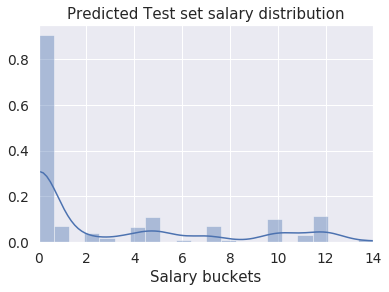

In [0]:
ax = sns.distplot(y_pred3)
plt.xlabel('Salary buckets')
plt.xlim(0,14)
plt.title('Predicted Test set salary distribution')


Text(0.5, 1.0, 'Actual Test set salary distribution')

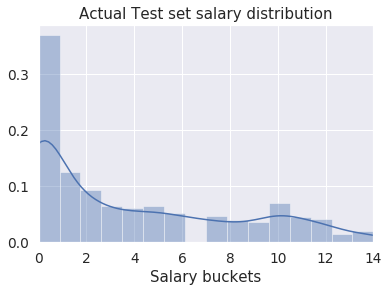

In [0]:
ax = sns.distplot(y_test)
plt.xlabel('Salary buckets')
plt.xlim(0,14)
plt.title('Actual Test set salary distribution')

## 6.2.2. Distribution 2 discussion

Out put the predicted result: One respondant's probability belongs to all target salary buckets.

In [0]:
#instead of outputting argmax of the predict_proba, output one respondant all probabilities.
def OrdinalLogisticRegression_predict_proba_out(X,one_rest):
  #predict_proba(X) calculated the probability of belonging to each of the salary buckets
  predicted = {y: one_rest[y].predict_proba(X) for y in one_rest}
  predicted_result =[] #contain probability of belonging to each of the salary buckets

  for i in y_class:
    if i == 0: #0 vs. 1-14
      predicted_result.append(1-predicted[i][:,1])
    elif i in predicted: #all middles
      predicted_result.append(predicted[i-1][:,1]-predicted[i][:,1])
    else: #last one
      predicted_result.append(predicted[i-1][:,1])

  predicted_result = np.vstack(predicted_result).T

  return predicted_result

Actual target salary bucket= 14
Poor match


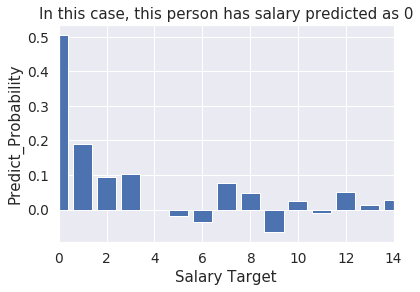

In [0]:
clfs4=GS_OrdinalLogisticRegression_fit(X_test, y_test,best_params)
y_pred4 = OrdinalLogisticRegression_predict_proba_out(X_test, clfs4)
a=y_pred4[500] 
b=y_test.iloc[500]
plt.bar(y_class,a)
plt.xlim(0,14)
plt.xlabel('Salary Target')
plt.ylabel('Predict_Probability')
plt.title('In this case, this person has salary predicted as 0')
print('Actual target salary bucket=', b)
print('Poor match')

Actual target salary bucket= 0
Good match


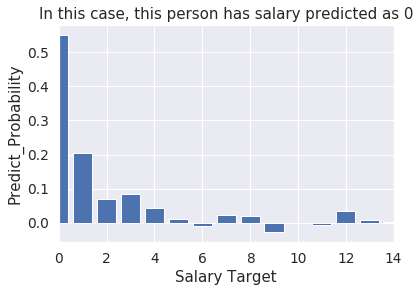

In [0]:
clfs4=GS_OrdinalLogisticRegression_fit(X_test, y_test,best_params)
y_pred4 = OrdinalLogisticRegression_predict_proba_out(X_test, clfs4)
a=y_pred4[700] 
b=y_test.iloc[700]
plt.bar(y_class,a)
plt.xlim(0,14)
plt.xlabel('Salary Target')
plt.ylabel('Predict_Probability')
plt.title('In this case, this person has salary predicted as 0')
print('Actual target salary bucket=', b)
print('Good match')

Canadiate 700 would be considered as a good fit, and canadiate 500 is a poor match

Done!